Pontifícia Universidade Católica de São Paulo 

`Ciência de Dados e Inteligência Artificial`

🎓 Laboratório 8 - Regressão Logística

---
> 👨‍🏫*Professor Rooney Coelho (rracoelho@pucsp.br)*
---

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

## Como funciona a regressão logística?

Temos apenas dois pratos, $x_1$ e $x_2$. Eles são pratos japoneses e italianos, respectivamente, e indicamos suas características de ingredientes com 0's e 1's.

* Passo 1

Imagine que já treinamos nosso regressor logístico binário e os *Parâmetros* já foram determinados. Cada $\beta$ representa um parâmetro que treinamos. Vamos agora conectar os recursos de nossos dois pratos na equação de regressão $f(x)$ que é a **soma** do **produto** de nossas entradas e parâmetros.

* Passo 2

Essa é a parte importante! Agora, inserimos o resultado anterior na função logística (logit) que gerará um valor entre 0 e 1. Esse valor pode ser interpretado como uma *probabilidade* de qualquer classe.

Nossos dois pratos, depois de serem passados por meio de regressão logística, foram mapeados em uma função logit com seus valores $y$ significando o quanto eles pertencem a qualquer classe. Quanto mais à direita você for, mais italiano será o prato e quanto mais à esquerda mais japonês.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2_linear_classifiers/images/summary.png" alt="drawing" width="1150">
<!-- ![Diagram](Picture1.png){ width : 50% } -->

## Exemplo 1 - Problema de Classificação: Prevendo os tipos de cozinha

Vamos realizar um exercício de classificação simples nos dados da receita. Sua tarefa é encontrar o tipo específico de cozinha com base nesses dados.

Vamos começar carregando os dados da receita em um `pandas.DataFrame`:

*NOTA: Algumas células levarão muito tempo para serem executadas!!!*

In [2]:
df = pd.read_json('data.json').set_index("id")
df

,cuisine,ingredients
id,,
10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
22213,indian,"[water, vegetable oil, wheat, salt]"
13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...
29109,irish,"[light brown sugar, granulated sugar, butter, ..."
11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."


Como você pode ver, cada prato tem uma lista completa de ingredientes associados a ele. Precisamos processá-los de alguma forma para conectá-los à nossa função de regressão logística, que nos ajudará a classificar cada prato em suas cozinhas.

Mostre aqui todas as cozinhas presentes na base de dados usando valores únicos.

In [3]:
# Cozinhas presentes na base de dados
df['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

Faça um histograma para a origem dos pratos.

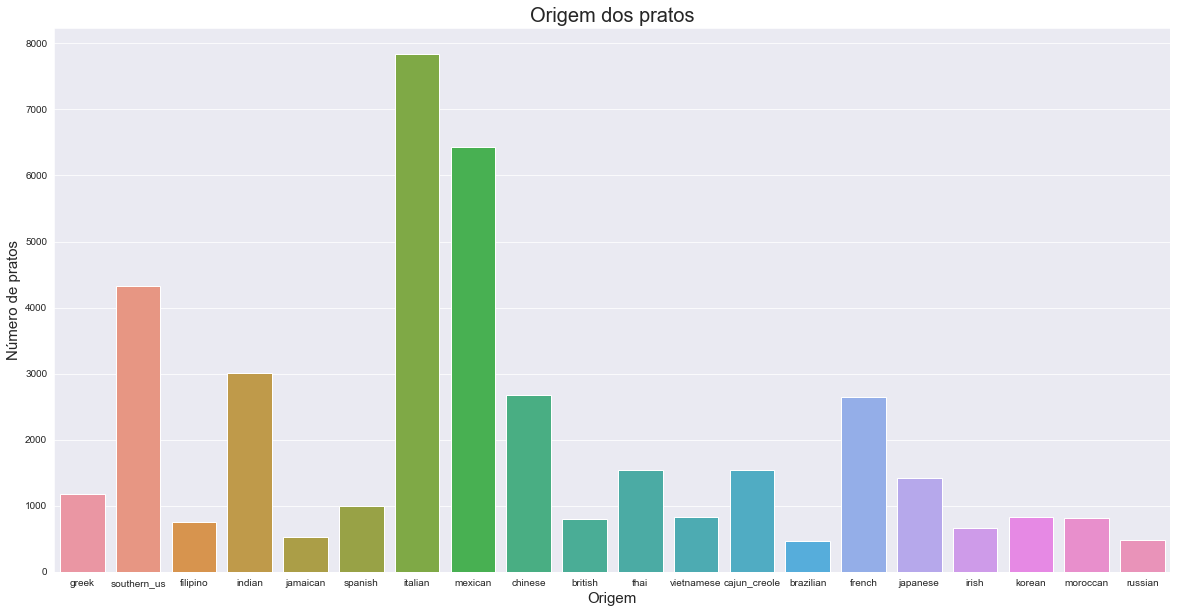

In [25]:
# Histograma
sns.set_style('darkgrid')
plt.figure(figsize = (20, 10))# maior
sns.countplot(x = 'cuisine', data = df)
plt.title('Origem dos pratos', fontsize = 20)
plt.xlabel('Origem', fontsize = 15)
plt.ylabel('Número de pratos', fontsize = 15)
plt.show()

Agora, vamos pensar em como podemos usar ingredientes para representar um prato. Você pode pensar imediatamente em usar apenas os nomes dos ingredientes para representar um prato. Antes de fazermos isso, vamos analisar os ingredientes.

Faça um histograma que descreve a frequência de cada comprimento da lista de ingredientes. Lembre-se que cada ingrediente é uma lista, então calcule o comprimento de cada lista de ingredientes para gerar este histograma.

 Vemos que o comprimento médio da lista de ingredientes é em torno de 10, com o máximo próximo a 30.

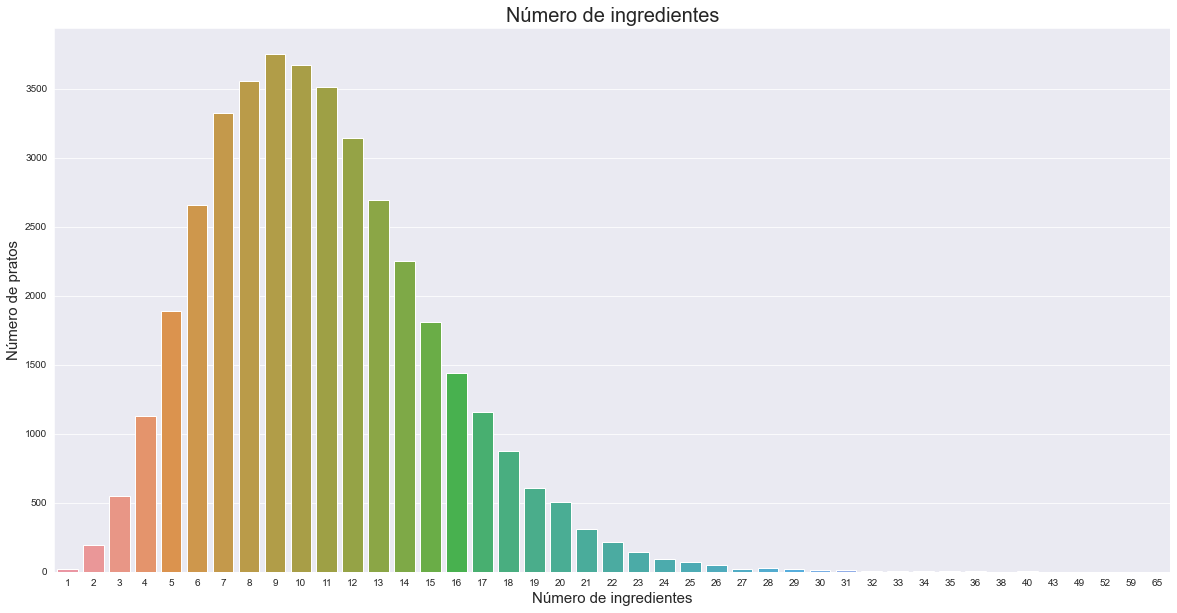

In [27]:
df['ingredients_length'] = df['ingredients'].apply(len)
sns.set_style('darkgrid')
plt.figure(figsize = (20, 10))# maior
sns.countplot(x = 'ingredients_length', data = df)
plt.title('Número de ingredientes', fontsize = 20)
plt.xlabel('Número de ingredientes', fontsize = 15)
plt.ylabel('Número de pratos', fontsize = 15)
plt.show()


Se criássemos uma matriz onde cada ingrediente fosse uma coluna, e tudo o que significasse se esse ingrediente estivesse em um determinado prato, quantas colunas teríamos?

Podemos usar o método `pd.Series.explode()` na coluna `ingredients` para mesclar as listas de ingredientes em uma grande série de pandas de todos os ingredientes.

In [28]:
all_ingredients = df['ingredients'].explode()
all_ingredients

id
10259    romaine lettuce
10259       black olives
10259     grape tomatoes
10259             garlic
10259             pepper
              ...       
2362              garlic
2362         white sugar
2362       roma tomatoes
2362              celery
2362       dried oregano
Name: ingredients, Length: 428275, dtype: object

Esta lista contém todos os ingredientes de cada receita, mas isso não é útil porque temos duplicatas como `alho` e muitos outros. Se executarmos um `pd.Series.unique()` podemos eliminar todas as duplicatas.

Faça a contagem de ingredientes únicos:

In [30]:
# Counting the number of unique ingredients
all_ingredients.nunique()

6714

Isso é um monte de ingredientes; se tivéssemos colunas `6714` para linhas de dados `39774`, teríamos uma matriz de células `267.042.636`! Isso é muito grande. Precisamos de uma maneira de extrair informações importantes sem sobrecarregar nosso sistema com uma quantidade louca de cálculos.

### Modelo Bag-of-Words

Como estamos trabalhando com texto, uma coisa simples e fácil de fazer é mesclar a lista de ingredientes de cada prato em uma string e usar as palavras dessa string para representar o prato. Isso nos dará uma compreensão rápida e fácil de quais ingredientes entram em um prato.

Essa representação de um prato pela contagem de cada ingrediente é chamada de **Bag-of-Words** de um ponto de dados usando suas palavras/ingredientes em um espaço dimensional $n$.

Para fazer isso, usaremos o método sklearn `CountVectorizer`.

```python
CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
```

In [31]:
# Converter uma lista em uma string
df['ingredients'].astype(str)[0].strip('[]')

"'mussels', 'ground black pepper', 'garlic cloves', 'saffron threads', 'olive oil', 'stewed tomatoes', 'arborio rice', 'minced onion', 'medium shrimp', 'fat free less sodium chicken broth', 'green peas'"

Parece uma boa e detalhada lista de ingredientes! Uma preocupação que podemos ter é o quão detalhados queremos que nossos ingredientes sejam. A especificação de `'fat free less sodium chicken broth'` fornece mais informações sobre um termo mais simples como `'chicken broth'`?

## n-gramas

Podemos usar o argumento `ngram_range` para limitar o número de palavras em um determinado ingrediente. Se definirmos para `(1,2)`, nosso `CountVectorizer` irá olhar apenas uma ou duas palavras de cada vez, como `chicken` e `chicken broth`, mas não `fat free less sodium chicken broth`. Isso pode significar que termos como "fat free" ou "less sodium" se tornarão "ingredients", mas não terão sentido! Isso pode ser ignorado, pois selecionaremos os principais recursos por sua frequência em todas as receitas.

In [32]:
#pegue os ingredientes do conjunto de treinamento
ingredients = df['ingredients'].astype(str).apply(lambda x: x.strip('[]'))

Use a função `CountVectorizer` para bigramas, usando um range `(1,2)` e para `200` features: 

In [33]:
# vetorizar os ingredientes para bigramas para 200 features
cv = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), max_features = 200)

Sendo `cv` o resultado do processamento de `CountVectorizer`, crie um DataFrame da seguinte forma:

```python
tf = cv.fit_transform(ingredients)

df_vectorized = pd.DataFrame(tf.toarray(), columns=cv.get_feature_names_out())
df_vectorized
```

In [35]:
# fit e transformar os ingredientes
tf = cv.fit_transform(ingredients)

# converter a matriz de contagem em um dataframe
df_vectorized = pd.DataFrame(tf.toarray(), columns = cv.get_feature_names_out())
df_vectorized

,all,all purpose,avocado,baking,baking powder,basil,bay,beans,beef,bell,...,vegetable oil,vinegar,virgin,virgin olive,water,white,white wine,whole,wine,yellow
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,1,0,0
39770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,0,0,0,2,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


* A matriz é muito esparsa! Muitos pratos (linhas) terão uma tonelada de 0s
* Os números são muito pequenos, geralmente 1 ou no máximo 2
* Palavras como `all, all purpose, baking, virgin, white e yellow` não têm muito significado. Provavelmente devemos removê-los.

Remova as seguintes palavras sem sentido que podem ser geradas pelo n-grama.

In [36]:
excludedWords = ['all', 'all purpose', 'baking', 'brown', 'cooked', 'cooking', 'diced', 'dried', 'dry',
                 'extra', 'extra virgin', 'extract', 'grated', 'green', 'ground', 'heavy', 'hot', 
                 'italian', 'kosher', 'large', 'low', 'minced', 'light', 'powder', 'purple', 'purpose',
                 'purpose flour', 'red', 'sea', 'skinless', 'sliced', 'sodium chicken','sour','unsalted',
                 'virgin', 'white','whole','yellow']

Quando você trabalha com dados de texto, especialmente incorporações de palavras, geralmente não é recomendado remover recursos manualmente dessa forma, pois é subjetivo e não reproduzível. Com o raciocínio apropriado, no entanto, poderia ser aceitável.

Use o método `drop` do pandas para remover as colunas cujo nome são `excludedWords`.

In [37]:
# Remover as excludedWords do dataframe
df_vectorized = df_vectorized.drop(excludedWords, axis = 1)
df_vectorized

,avocado,baking powder,basil,bay,beans,beef,bell,bell pepper,black,black pepper,...,unsalted butter,vanilla,vanilla extract,vegetable,vegetable oil,vinegar,virgin olive,water,white wine,wine
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
4,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
39770,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
39771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


Usando esse conjunto de dados, agora podemos aplicar a **Regressão Logística**.

### Nota sobre embeddings 

O que temos aqui é uma matriz de frequência de termos muito simples. Como é essencialmente uma codificação one-hot, é muito simples em comparação com matrizes de frequência de termos para outros tópicos de PLN.

Outra matriz popular para usar em PLN é a matriz **tf-idf**, que significa a matriz **frequência do termo - frequência inversa do documento**. Essa matriz aumenta os termos na matriz de frequência de termos de modo que mais palavras *importantes/especiais* para um determinado documento tenham valores mais altos do que palavras que ocorrem com frequência, como *"o" ou "e"*. Usando essa matriz, você pode criar incorporações de documentos mais significativas, o que pode ajudar em vários aplicativos que exigem representações precisas de documentos.

### Divisão dos dados

Faça aqui a divisão dos dados usando o train_test_split, separe 25% dos dados para teste. Uma vez que os dados estão desbalanceados, use `stratify=df['cuisine']` como argumento desta função para dividir os dados na mesma proporção.

In [41]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(df_vectorized, df['cuisine'], stratify = df['cuisine'], test_size = 0.2, random_state = 42)

Execute a célula abaixo para conferir se a mesma proporção de treino e teste foi respeitada:

In [42]:
aux1 = y_train.value_counts().sort_values(ascending=False)
aux2 = y_test.value_counts().sort_values(ascending=False)

aux1 = aux1/sum(aux1) * 100
aux2 = aux2/sum(aux2) * 100

# Imprir de forma tabelada para comparação
pd.concat([aux1, aux2], axis=1)

,cuisine,cuisine
italian,19.705208,19.710874
mexican,16.185298,16.191075
southern_us,10.861435,10.861094
indian,7.548949,7.554997
chinese,6.719256,6.725330
french,6.653257,6.649906
cajun_creole,3.887614,3.884349
thai,3.868758,3.871779
japanese,3.579622,3.570082
greek,2.954210,2.954117


Podemos confirmar que cada conjunto de dados tem a mesma distribuição de classes, portanto, ao treinar a regressão logística, poderemos generalizar e reduzir o risco de overfitting aos dados de treinamento! 

## Regressão Logística

Faça a regressão logística e coloque como argumento a quantidade máxima de iterações igual a `500`.

In [46]:
# Regressão Logística
lr = LogisticRegression(random_state = 42, max_iter = 500)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

Imprima agora o `classification_report` para analisarmos a performance do algoritmo.

In [47]:
# Classification report
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

   brazilian       0.53      0.33      0.41        93
     british       0.41      0.17      0.24       161
cajun_creole       0.72      0.58      0.64       309
     chinese       0.71      0.75      0.73       535
    filipino       0.57      0.35      0.43       151
      french       0.47      0.44      0.46       529
       greek       0.55      0.31      0.40       235
      indian       0.77      0.82      0.80       601
       irish       0.43      0.27      0.33       133
     italian       0.65      0.80      0.72      1568
    jamaican       0.75      0.50      0.60       105
    japanese       0.49      0.45      0.47       284
      korean       0.62      0.61      0.62       166
     mexican       0.84      0.86      0.85      1288
    moroccan       0.74      0.58      0.65       164
     russian       0.45      0.20      0.28        98
 southern_us       0.50      0.66      0.57       864
     spanish       0.51    

Os resultados são meio sem graça... o que podemos fazer?

* Implementando validação cruzada
* Aumente a quantidade de features!
* Usando mais ngramas para o Count Vectorizer
* Algoritmos de redução de dimensionalidade
* Testar vários tamanhos de conjuntos de treinamento/teste

### Implementação da validação cruzada

A validação cruzada é a prática de pegar um conjunto aleatório de dentro dos dados de treinamento e usá-lo para otimizar o algoritmo. Isso melhora a capacidade de generalizar (desempenha bem quando recebe novos dados)

![CV-Example](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2\_linear_classifiers/images/K-fold_cross_validation.svg)

Faça agora o `LogisticRegressionCV` para a validação cruzada use 5 folds para isso e aumente o limite para 1000 iterações ou mais.

In [ ]:
# LEVA UM BOM TEMPO... Se sua máquina for limitada faça no Google Colab
# Regressão Logística com validação cruzada
lrcv = LogisticRegressionCV(random_state = 42, max_iter = 1500, cv = 5)
lrcv.fit(X_train, y_train)

Veja agora se a validação cruzada melhora a performance neste caso através do `classification_report`.

In [ ]:
# Classification report com validação cruzada
print(classification_report(y_test, lrcv.predict(X_test)))

## Aumentando a quantidade de features

Escreva neste bloco o código para refazer todo o processamento considerando agora `1000` features ao invés das `200` usadas anteriormente.

In [ ]:
# Treinando modelos com 1000 features ao invés de 200
# Vetorizar os ingredientes para bigramas para 1000 features
cv2 = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), max_features = 1000)
tf2 = cv2.fit_transform(ingredients)
df_vectorized2 = pd.DataFrame(tf2.toarray(), columns = cv.get_feature_names_out())
df_vectorized2 = df_vectorized2.drop(excludedWords, axis = 1)

# train test split para 1000 features
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_vectorized2, df['cuisine'], stratify = df['cuisine'], test_size = 0.25, random_state = 42)

# Regressão Logística com validação cruzada para 1000 features
lrcv2 = LogisticRegressionCV(random_state = 42, max_iter = 1500, cv = 5)
lrcv2.fit(X_train2, y_train2)

# Classification report com validação cruzada para 1000 features
print(classification_report(y_test2, lrcv2.predict(X_test2)))

Podemos ver que agora a precisão do modelo aumentou consideravelmente!

## Conclusão

Fizemos o nosso melhor para classificar as cozinhas usando a análise textual, mas parece que ainda é muito difícil alcançar uma precisão super alta devido aos dados que temos. Muitas vezes, no aprendizado de máquina, você encontrará problemas que simplesmente não consegue resolver para determinados requisitos, como uma precisão de 90% ou mais. Os dados que você recebe podem não ter informações, você pode precisar limpar ainda mais seus dados ou o algoritmo que você emprega pode simplesmente não funcionar bem com o caso de uso. Neste exemplo, tentamos muitos métodos para processar nossos dados e aumentar a precisão, mas apenas marginalmente.